# Algorithme Génétique

## Principe Général

Un **algorithme génétique** est une méthode d’optimisation inspirée du processus de l’évolution naturelle. Il repose sur trois grands principes : **variation**, **adaptation** et **hérédité**.

Chaque **individu** représente une solution possible au problème (par exemple, un trajet dans le cas du problème du voyageur de commerce), codé sous forme de **chromosome** (liste de villes).

---

## Termes Clés

- **Individu** : un trajet possible  
- **Population** : un ensemble de trajets  
- **Mutation** : modification aléatoire d’un trajet  
- **Adaptation** : plus le trajet est court, plus il est adapté  
- **Sélection naturelle** : les moins adaptés sont éliminés

---

## Fonctionnement Étape par Étape

### 1. Initialisation de la Population
Création aléatoire d’une population d’individus. Cette diversité initiale est essentielle pour explorer efficacement l’espace des solutions.

### 2. Évaluation de l’Aptitude (*Fitness*)
Chaque individu est évalué selon une **fonction d’aptitude**, qui mesure la qualité de la solution (ex: distance totale du trajet).

### 3. Sélection
Les meilleurs individus sont choisis pour se reproduire.  
Méthodes courantes : **roulette**, **tournoi**, etc.  
Objectif : favoriser les bons candidats, tout en conservant une certaine diversité.

### 4. Croisement (*Crossover*)
Des couples d’individus sélectionnés produisent des **descendants** en combinant leurs chromosomes. Cela permet de créer de nouvelles solutions à partir des meilleures existantes.

### 5. Mutation
Des modifications aléatoires sont appliquées pour introduire de la nouveauté et éviter la stagnation. Cela permet de maintenir la diversité génétique.

### 6. Remplacement
Les nouveaux individus remplacent partiellement ou totalement la population précédente selon une stratégie choisie (ex: **élitisme**).

### 7. Itération
Les étapes sont répétées jusqu’à atteindre un critère d’arrêt :  
nombre de générations, seuil de qualité atteint, etc.

---

## Résumé Visuel du Cycle



In [1]:
import random
import numpy as np
from typing import List, Tuple, Set
import time
import matplotlib.pyplot as plt

In [2]:
def load_adjacency_matrix_and_collecte(file_path: str) -> Tuple[np.ndarray, List[int]]:
    """Charge la matrice d'adjacence et les points de collecte depuis un fichier CSV."""
    try:
        with open(file_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        # Dernière ligne contient les points de collecte
        points_collecte = list(map(int, lines[-1].split(';')))
        
        # Matrice d'adjacence dans les autres lignes
        matrix = []
        for line in lines[:-1]:
            row = list(map(int, line.split(';')))
            matrix.append(row)
            
        return np.array(matrix), points_collecte
        
    except FileNotFoundError:
        raise ValueError(f"Fichier {file_path} introuvable")
    except Exception as e:
        raise ValueError(f"Erreur lors de la lecture du fichier: {str(e)}")

## 1. Initialisation et Validation
 La classe GeneticTSP résout un problème de tournée avec contraintes spécifiques :
 - Doit commencer et finir à un point donné
 - Doit passer par certains points de collecte
 - Doit visiter toutes les villes exactement une fois

In [3]:
class GeneticTSP:
    def __init__(self, matrix: np.ndarray, collecte_points: List[int], start_node: int = 1):
        self.matrix = matrix
        self.collecte = set(collecte_points)
        self.start_node = start_node
        self.num_cities = len(matrix)
        self.best_solution = None
        self.best_cost = float('inf')
        self.cost_history = []
        
        # Pré-calcul des villes accessibles depuis chaque ville
        self.accessible_from = {
            i: [j for j in range(1, self.num_cities+1) if matrix[i-1][j-1] != -1]
            for i in range(1, self.num_cities+1)
        }
        
        # Validation des entrées
        self._validate_inputs()
    
    def _validate_inputs(self):
        if len(self.matrix.shape) != 2 or self.matrix.shape[0] != self.matrix.shape[1]:
            raise ValueError("La matrice d'adjacence doit être carrée")
        if self.start_node < 1 or self.start_node > self.num_cities:
            raise ValueError(f"Le noeud de départ doit être entre 1 et {self.num_cities}")
        if not self.collecte:
            raise ValueError("Aucun point de collecte spécifié")

    def is_valid_path(self, path: List[int]) -> bool:
        """Vérifie si un chemin satisfait toutes les contraintes."""
        # Vérification basique
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        # Points de collecte
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        # Toutes villes visitées exactement une fois (sauf départ/arrivée)
        if len(set(path)) != self.num_cities:
            return False
            
        # Chemins valides
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
                
        return True

    def calculate_cost(self, path: List[int]) -> int:
        """Calcule le coût total d'un chemin."""
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

    def _greedy_construction(self) -> List[int]:
        """Construit une solution initiale avec une approche gloutonne en respectant les contraintes."""
        path = [self.start_node]
        unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
        
        # Premier mouvement vers le point de collecte le plus proche
        collect_candidates = [c for c in self.collecte if c in unvisited and 
                            self.matrix[self.start_node-1][c-1] != -1]
        if not collect_candidates:
            return None
            
        nearest_collect = min(collect_candidates, 
                            key=lambda x: self.matrix[self.start_node-1][x-1])
        path.append(nearest_collect)
        unvisited.remove(nearest_collect)
        
        # Construction gloutonne du chemin
        while unvisited:
            last = path[-1]
            
            # Filtrer les villes accessibles non visitées
            candidates = [c for c in self.accessible_from[last] if c in unvisited]
            
            if not candidates:
                # Si aucun candidat valide, essayer de trouver un chemin valide
                candidates = list(unvisited)
                random.shuffle(candidates)
                
            # Sélectionner la ville la plus proche accessible
            next_city = None
            min_dist = float('inf')
            for c in candidates:
                if self.matrix[last-1][c-1] < min_dist and self.matrix[last-1][c-1] != -1:
                    min_dist = self.matrix[last-1][c-1]
                    next_city = c
            
            if next_city is None:
                return None
                
            path.append(next_city)
            unvisited.remove(next_city)
        
        # Retour au point de départ
        if self.matrix[path[-1]-1][self.start_node-1] == -1:
            return None
            
        path.append(self.start_node)
        
        return path if self.is_valid_path(path) else None

    def generate_initial_population(self, size: int) -> List[List[int]]:
        """Génère une population initiale diversifiée."""
        population = []
        
        # 1. Solutions gloutonnes variées
        for _ in range(size//2):
            sol = self._greedy_construction()
            if sol:
                population.append(sol)
        
        # 2. Solutions semi-aléatoires avec contraintes respectées
        while len(population) < size:
            path = [self.start_node]
            unvisited = set(range(1, self.num_cities+1)) - {self.start_node}
            
            # Ajout d'un point de collecte en deuxième position
            collect_candidates = [c for c in self.collecte if c in unvisited and 
                                self.matrix[self.start_node-1][c-1] != -1]
            if not collect_candidates:
                break
                
            collect_point = random.choice(collect_candidates)
            path.append(collect_point)
            unvisited.remove(collect_point)
            
            # Construction aléatoire mais valide du chemin
            while unvisited:
                last = path[-1]
                candidates = [c for c in self.accessible_from[last] if c in unvisited]
                
                if not candidates:
                    break
                    
                next_city = random.choice(candidates)
                path.append(next_city)
                unvisited.remove(next_city)
            
            # Retour au départ si possible
            if unvisited or self.matrix[path[-1]-1][self.start_node-1] == -1:
                continue
                
            path.append(self.start_node)
            
            if self.is_valid_path(path):
                population.append(path)
        
        return population[:size]

    def tournament_selection(self, population: List[List[int]], tournament_size: int = 5) -> List[List[int]]:
        """Sélection par tournoi."""
        selected = []
        for _ in range(len(population)):
            participants = random.sample(population, min(tournament_size, len(population)))
            winner = min(participants, key=lambda x: self.calculate_cost(x))
            selected.append(winner)
        return selected

    def ordered_crossover(self, parent1: List[int], parent2: List[int]) -> List[int]:
        """Croisement ordonné pour préserver les permutations valides."""
        size = len(parent1)
        start, end = sorted(random.sample(range(1, size-1), 2))
        
        def create_child(p1, p2):
            child = [None]*size
            child[0] = child[-1] = self.start_node
            
            # Copier le segment entre start et end
            child[start:end] = p1[start:end]
            
            # Remplir avec les villes de p2 dans l'ordre
            remaining = [city for city in p2 if city not in child[start:end]]
            ptr = 1
            for i in range(1, size-1):
                if child[i] is None:
                    child[i] = remaining[ptr-1]
                    ptr += 1
            return child
        
        child1 = create_child(parent1, parent2)
        child2 = create_child(parent2, parent1)
        
        # Validation des enfants
        valid_child1 = child1 if self.is_valid_path(child1) else parent1
        valid_child2 = child2 if self.is_valid_path(child2) else parent2
        
        return valid_child1, valid_child2

    def mutate(self, path: List[int], mutation_rate: float = 0.1) -> List[int]:
        """Mutation par échange de deux villes."""
        if random.random() > mutation_rate or len(path) <= 3:
            return path
            
        # On ne mute pas le départ, l'arrivée ou les points de collecte contraints
        mutable_positions = list(range(1, len(path)-1))
        if len(path) > 3:
            mutable_positions.remove(1)  # Ne pas muter le premier point de collecte
        if len(path) > 4:
            mutable_positions.remove(len(path)-2)  # Ne pas muter l'avant-dernier point
            
        if len(mutable_positions) < 2:
            return path
            
        i, j = random.sample(mutable_positions, 2)
        new_path = path.copy()
        new_path[i], new_path[j] = new_path[j], new_path[i]
        
        return new_path if self.is_valid_path(new_path) else path

    def solve(self, population_size: int = 100, generations: int = 200, 
             mutation_rate: float = 0.15, elite_size: int = 10):
        """Algorithme génétique principal."""
        start_time = time.time()
        
        # Initialisation
        population = self.generate_initial_population(population_size)
        if not population:
            raise ValueError("Impossible de générer une population initiale valide. " +
                           "Vérifiez les contraintes et la matrice d'adjacence.")
            
        population.sort(key=lambda x: self.calculate_cost(x))
        self.best_solution = population[0]
        self.best_cost = self.calculate_cost(population[0])
        self.cost_history.append(self.best_cost)
        
        # Évolution
        for gen in range(generations):
            # Sélection élitiste
            elites = population[:elite_size]
            
            # Sélection
            selected = self.tournament_selection(population)
            
            # Croisement
            offspring = []
            for i in range(0, len(selected)-1, 2):
                child1, child2 = self.ordered_crossover(selected[i], selected[i+1])
                offspring.append(child1)
                offspring.append(child2)
            
            # Mutation
            mutated = [self.mutate(child, mutation_rate) for child in offspring]
            
            # Nouvelle population
            population = elites + mutated
            population.sort(key=lambda x: self.calculate_cost(x))
            population = population[:population_size]
            
            # Mise à jour meilleure solution
            current_best = population[0]
            current_cost = self.calculate_cost(current_best)
            if current_cost < self.best_cost:
                self.best_solution = current_best
                self.best_cost = current_cost
            self.cost_history.append(self.best_cost)
            
            # Affichage progression
            if gen % 10 == 0:
                avg_cost = np.mean([self.calculate_cost(p) for p in population])
                print(f"Gen {gen}: Best={self.best_cost} Avg={avg_cost:.1f}")
        
        print(f"\nOptimisation terminée en {time.time()-start_time:.2f}s")
        print(f"Meilleur coût trouvé: {self.best_cost}")
        print(f"Solution valide: {self.is_valid_path(self.best_solution)}")
        
        # Visualisation
        plt.plot(self.cost_history)
        plt.title("Évolution du meilleur coût")
        plt.xlabel("Génération")
        plt.ylabel("Coût")
        plt.show()
        
        return self.best_solution, self.best_cost

## 2. Vérification et Calcul des Solutions
### Contrôle de validité d'un chemin
Un chemin valide doit :
1. Commencer et finir au point de départ
2. Passer par un point de collecte en 2ème position
3. Visiter toutes les villes exactement une fois
4. Ne contenir que des connexions valides (pas de -1 dans la matrice)

In [4]:
    def is_valid_path(self, path: List[int]) -> bool:
        if (len(path) != self.num_cities + 1 or 
            path[0] != self.start_node or 
            path[-1] != self.start_node):
            return False
            
        if path[1] not in self.collecte or path[-2] in self.collecte:
            return False
            
        if len(set(path)) != self.num_cities:
            return False
            
        for i in range(len(path)-1):
            if self.matrix[path[i]-1][path[i+1]-1] == -1:
                return False
        return True

    def calculate_cost(self, path: List[int]) -> int:
        return sum(self.matrix[path[i]-1][path[i+1]-1] for i in range(len(path)-1))

## 3. Construction des Solutions Initiales
Stratégie hybride pour la population initiale :
- 50% de solutions gloutonnes (optimisées localement)
- 50% de solutions aléatoires (diversité)

## 4. Opérateurs Génétiques
### Sélection par Tournoi
- Sélectionne les meilleurs individus par compétition
- Maintient la pression de sélection

### Croisement Ordonné (OX)
- Préserve l'ordre des villes
- Garantit des solutions valides
- Combine des segments de parents

### Mutation Contrôlée
- Échange deux villes aléatoirement
- Préserve les contraintes de collecte
- Taux de mutation paramétrable

## 5. Algorithme Principal
### Processus Évolutif
1. Initialisation de la population
2. Sélection des parents
3. Croisement et mutation
4. Élitisme (conservation des meilleurs solutions)
5. Convergence vers une solution optimale

## Choix des paramètres pour l'heuristique d'Algorithme Génétique (GA)

Afin d'optimiser la résolution du problème pour différentes tailles de villes, les paramètres suivants sont choisis :

| Taille (nombre de villes) | Taille de la population (`population_size`) | Nombre de générations (`n_generations`) | Taux de croisement (`crossover_rate`) | Taux de mutation (`mutation_rate`) | Sélection |
|:---|:---|:---|:---|:---|:---|
| 10 | 20 | 50 | 0.9 | 0.2 | Tournoi |
| 20 | 40 | 100 | 0.9 | 0.2 | Tournoi |
| 30 | 60 | 150 | 0.9 | 0.15 | Tournoi |
| 40 | 80 | 200 | 0.9 | 0.15 | Tournoi |
| 50 | 100 | 250 | 0.9 | 0.1 | Tournoi |
| 75 | 150 | 400 | 0.9 | 0.1 | Tournoi |
| 100 | 200 | 500 | 0.9 | 0.05 | Tournoi |

### Explication des choix

- **Taille de la population (`population_size`)** : proportionnelle au nombre de villes pour garantir une diversité génétique suffisante.
- **Nombre de générations (`n_generations`)** : augmente avec la taille du problème pour permettre la convergence vers de meilleures solutions.
- **Taux de croisement (`crossover_rate`)** : fixé à 0.9 pour assurer un fort échange génétique entre les solutions.
- **Taux de mutation (`mutation_rate`)** : légèrement plus faible pour les grandes instances pour éviter de casser les solutions prometteuses.
- **Méthode de sélection** : **Tournoi** (Tournament selection) pour favoriser les solutions robustes tout en conservant de la diversité.

### Recommandations supplémentaires

- **Élitisme** : Toujours conserver les meilleures solutions d'une génération à l'autre pour assurer la non-régression.
- **Mutation adaptative** : Diminuer légèrement le taux de mutation au fur et à mesure des générations pour stabiliser la recherche.
- **Croisement spécifique TSP** : Utiliser des opérateurs de croisement adaptés au problème de tournée comme **Order Crossover (OX)** ou **Partially Mapped Crossover (PMX)**.


## Paramètres :

- population_size : Augmente la diversité mais nécessite plus de calculs
- generations : Plus le nombre de générations est élevé, plus l'algorithme peux trouver de meilleures solution
- mutation_rate : Evite la stagnation dans les optima locaux
- elite_size : Nombre d'individus les mieux classés pour la génération suivante. Garantit que les meilleures solution ne sont pas perdues

Chargement du fichier ../data/matrice_routes_ordre_10.csv...

Paramètres du problème:
- Nombre de villes: 10
- Points de collecte: [3, 7]
- Taille de la matrice: (10, 10)
Gen 0: Best=554 Avg=738.1
Gen 10: Best=487 Avg=489.1
Gen 20: Best=487 Avg=494.2
Gen 30: Best=487 Avg=489.4
Gen 40: Best=487 Avg=496.4
Gen 50: Best=487 Avg=487.7
Gen 60: Best=487 Avg=491.2
Gen 70: Best=487 Avg=498.7
Gen 80: Best=487 Avg=494.9
Gen 90: Best=487 Avg=507.1
Gen 100: Best=487 Avg=495.1
Gen 110: Best=487 Avg=492.0
Gen 120: Best=487 Avg=495.6
Gen 130: Best=487 Avg=487.0
Gen 140: Best=487 Avg=492.7
Gen 150: Best=487 Avg=489.3
Gen 160: Best=487 Avg=502.5
Gen 170: Best=487 Avg=490.3
Gen 180: Best=487 Avg=496.5
Gen 190: Best=487 Avg=490.2

Optimisation terminée en 0.59s
Meilleur coût trouvé: 487
Solution valide: True


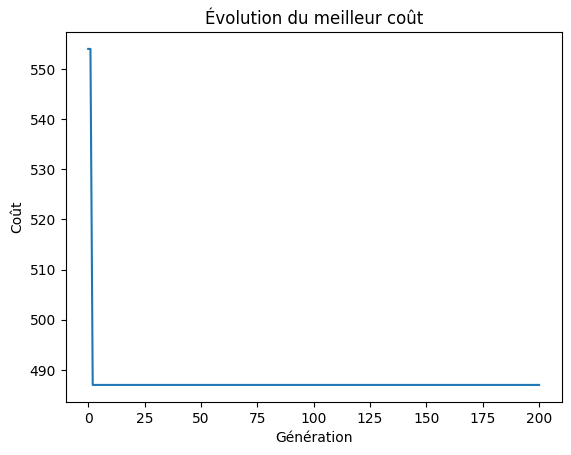


Meilleur chemin trouvé (extrait):
Départ: [1, 7, 10]...[2, 8, 1]
Longueur: 11 villes
Coût total: 487
Chargement du fichier ../data/matrice_routes_ordre_20.csv...

Paramètres du problème:
- Nombre de villes: 20
- Points de collecte: [5, 13]
- Taille de la matrice: (20, 20)
Gen 0: Best=1025 Avg=1025.0
Gen 10: Best=1016 Avg=1016.0
Gen 20: Best=1016 Avg=1016.0
Gen 30: Best=1016 Avg=1017.6
Gen 40: Best=1016 Avg=1016.0
Gen 50: Best=1016 Avg=1016.0
Gen 60: Best=1016 Avg=1016.0
Gen 70: Best=1016 Avg=1016.0
Gen 80: Best=1016 Avg=1016.0
Gen 90: Best=1016 Avg=1016.0
Gen 100: Best=1016 Avg=1016.0
Gen 110: Best=1016 Avg=1016.0
Gen 120: Best=1016 Avg=1016.0
Gen 130: Best=1016 Avg=1016.0
Gen 140: Best=1016 Avg=1016.0
Gen 150: Best=1016 Avg=1016.0
Gen 160: Best=1016 Avg=1016.0
Gen 170: Best=1016 Avg=1016.0
Gen 180: Best=1016 Avg=1016.0
Gen 190: Best=1016 Avg=1016.0

Optimisation terminée en 0.96s
Meilleur coût trouvé: 1016
Solution valide: True


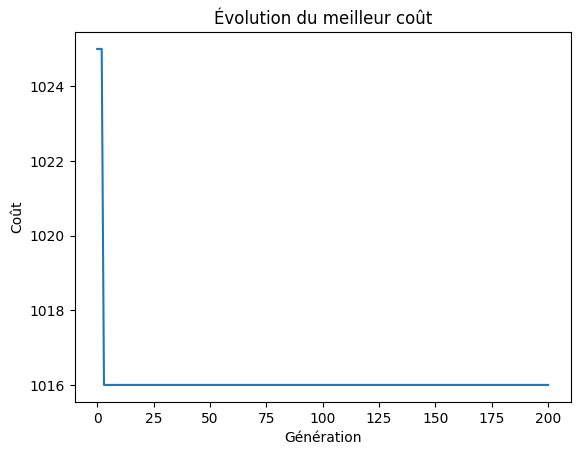


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 5]...[10, 7, 1]
Longueur: 21 villes
Coût total: 1016
Chargement du fichier ../data/matrice_routes_ordre_30.csv...

Paramètres du problème:
- Nombre de villes: 30
- Points de collecte: [5, 14]
- Taille de la matrice: (30, 30)
Gen 0: Best=1056 Avg=1071.5
Gen 10: Best=1008 Avg=1008.0
Gen 20: Best=1008 Avg=1008.0
Gen 30: Best=1008 Avg=1008.0
Gen 40: Best=1008 Avg=1008.0
Gen 50: Best=1008 Avg=1015.2
Gen 60: Best=1008 Avg=1008.8
Gen 70: Best=1008 Avg=1008.0
Gen 80: Best=1008 Avg=1008.0
Gen 90: Best=1008 Avg=1008.0
Gen 100: Best=1008 Avg=1008.0
Gen 110: Best=1008 Avg=1010.3
Gen 120: Best=1008 Avg=1011.2
Gen 130: Best=1008 Avg=1008.0
Gen 140: Best=1008 Avg=1008.0
Gen 150: Best=1008 Avg=1008.0
Gen 160: Best=1008 Avg=1008.0
Gen 170: Best=1008 Avg=1015.0
Gen 180: Best=1008 Avg=1016.8
Gen 190: Best=1008 Avg=1008.0

Optimisation terminée en 1.35s
Meilleur coût trouvé: 1008
Solution valide: True


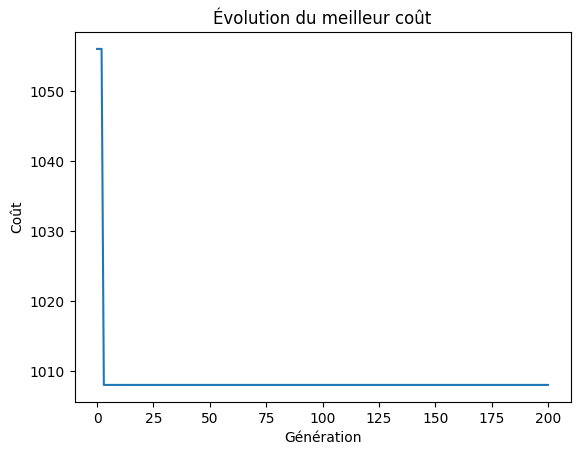


Meilleur chemin trouvé (extrait):
Départ: [1, 5, 9]...[7, 12, 1]
Longueur: 31 villes
Coût total: 1008
Chargement du fichier ../data/matrice_routes_ordre_40_Difficile.csv...

Paramètres du problème:
- Nombre de villes: 40
- Points de collecte: [37, 19]
- Taille de la matrice: (40, 40)
Gen 0: Best=782 Avg=782.0
Gen 10: Best=782 Avg=782.0
Gen 20: Best=782 Avg=782.0
Gen 30: Best=782 Avg=782.0
Gen 40: Best=782 Avg=782.0
Gen 50: Best=782 Avg=782.0
Gen 60: Best=782 Avg=782.0
Gen 70: Best=782 Avg=782.0
Gen 80: Best=782 Avg=784.7
Gen 90: Best=782 Avg=782.0
Gen 100: Best=782 Avg=782.0
Gen 110: Best=782 Avg=782.0
Gen 120: Best=782 Avg=783.3
Gen 130: Best=782 Avg=782.0
Gen 140: Best=782 Avg=782.0
Gen 150: Best=782 Avg=782.0
Gen 160: Best=782 Avg=782.0
Gen 170: Best=782 Avg=782.0
Gen 180: Best=782 Avg=782.0
Gen 190: Best=782 Avg=782.0

Optimisation terminée en 1.70s
Meilleur coût trouvé: 782
Solution valide: True


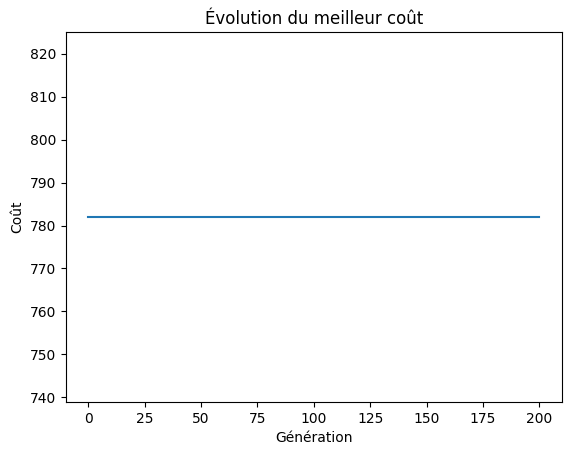


Meilleur chemin trouvé (extrait):
Départ: [1, 37, 40]...[30, 6, 1]
Longueur: 41 villes
Coût total: 782
Chargement du fichier ../data/matrice_routes_ordre_50.csv...

Paramètres du problème:
- Nombre de villes: 50
- Points de collecte: [34, 9]
- Taille de la matrice: (50, 50)
Gen 0: Best=3914 Avg=4341.1
Gen 10: Best=3374 Avg=3544.1
Gen 20: Best=2909 Avg=2973.7
Gen 30: Best=2752 Avg=2890.6
Gen 40: Best=2615 Avg=2656.3
Gen 50: Best=2339 Avg=2356.5
Gen 60: Best=2239 Avg=2239.0
Gen 70: Best=2192 Avg=2197.9
Gen 80: Best=2049 Avg=2049.0
Gen 90: Best=2001 Avg=2034.1
Gen 100: Best=1874 Avg=1887.3
Gen 110: Best=1811 Avg=1813.6
Gen 120: Best=1712 Avg=1808.2
Gen 130: Best=1655 Avg=1655.2
Gen 140: Best=1574 Avg=1574.0
Gen 150: Best=1542 Avg=1543.1
Gen 160: Best=1542 Avg=1542.0
Gen 170: Best=1525 Avg=1526.4
Gen 180: Best=1525 Avg=1525.0
Gen 190: Best=1525 Avg=1526.1

Optimisation terminée en 2.14s
Meilleur coût trouvé: 1525
Solution valide: True


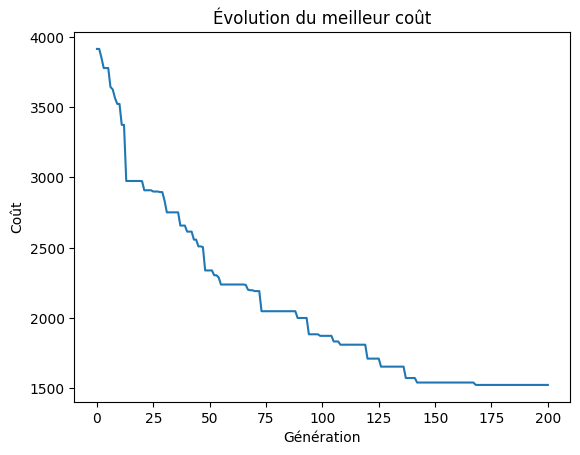


Meilleur chemin trouvé (extrait):
Départ: [1, 9, 41]...[5, 49, 1]
Longueur: 51 villes
Coût total: 1525
Chargement du fichier ../data/matrice_routes_ordre_75.csv...

Paramètres du problème:
- Nombre de villes: 75
- Points de collecte: [25, 37]
- Taille de la matrice: (75, 75)
Gen 0: Best=6329 Avg=6872.2
Gen 10: Best=5517 Avg=5666.9
Gen 20: Best=5066 Avg=5150.4
Gen 30: Best=4498 Avg=4518.8
Gen 40: Best=4203 Avg=4203.0
Gen 50: Best=4109 Avg=4111.2
Gen 60: Best=3914 Avg=3984.7
Gen 70: Best=3582 Avg=3639.5
Gen 80: Best=3431 Avg=3431.0
Gen 90: Best=3420 Avg=3427.1
Gen 100: Best=3164 Avg=3179.1
Gen 110: Best=2991 Avg=3059.6
Gen 120: Best=2951 Avg=2951.0
Gen 130: Best=2921 Avg=2921.0
Gen 140: Best=2893 Avg=2895.0
Gen 150: Best=2872 Avg=2872.0
Gen 160: Best=2872 Avg=2872.0
Gen 170: Best=2833 Avg=2868.1
Gen 180: Best=2775 Avg=2775.0
Gen 190: Best=2775 Avg=2778.9

Optimisation terminée en 3.16s
Meilleur coût trouvé: 2775
Solution valide: True


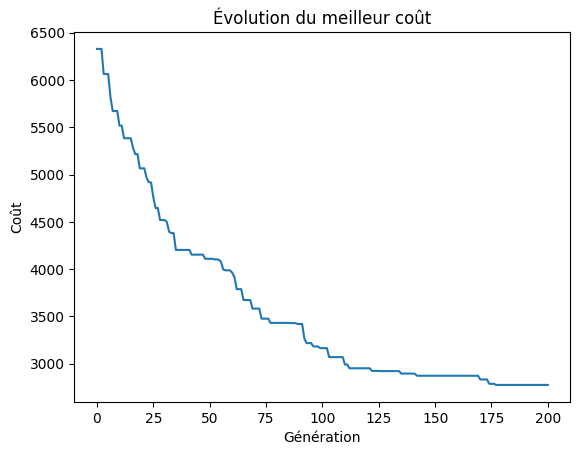


Meilleur chemin trouvé (extrait):
Départ: [1, 25, 46]...[73, 29, 1]
Longueur: 76 villes
Coût total: 2775
Chargement du fichier ../data/matrice_routes_ordre_100.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [46, 13]
- Taille de la matrice: (100, 100)
Gen 0: Best=8151 Avg=9223.1
Gen 10: Best=7727 Avg=7824.1
Gen 20: Best=7156 Avg=7320.2
Gen 30: Best=6707 Avg=6839.8
Gen 40: Best=6157 Avg=6351.8
Gen 50: Best=5826 Avg=5988.8
Gen 60: Best=5490 Avg=5569.2
Gen 70: Best=5307 Avg=5442.1
Gen 80: Best=4867 Avg=4986.7
Gen 90: Best=4711 Avg=4711.0
Gen 100: Best=4644 Avg=4679.6
Gen 110: Best=4454 Avg=4454.0
Gen 120: Best=4195 Avg=4314.3
Gen 130: Best=4037 Avg=4082.9
Gen 140: Best=3904 Avg=3910.7
Gen 150: Best=3788 Avg=3793.1
Gen 160: Best=3738 Avg=3795.3
Gen 170: Best=3738 Avg=3738.0
Gen 180: Best=3397 Avg=3500.0
Gen 190: Best=3299 Avg=3301.1

Optimisation terminée en 4.33s
Meilleur coût trouvé: 3237
Solution valide: True


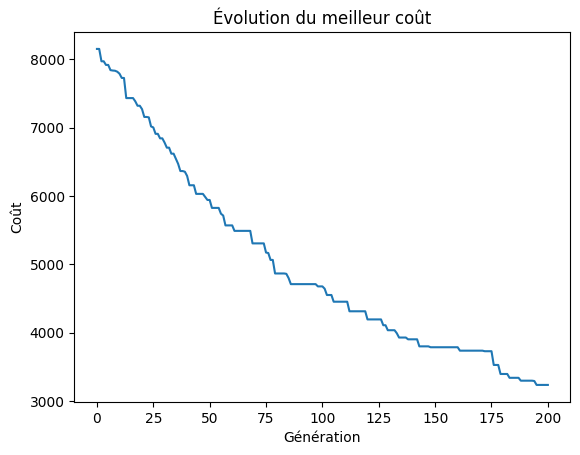


Meilleur chemin trouvé (extrait):
Départ: [1, 13, 64]...[53, 34, 1]
Longueur: 101 villes
Coût total: 3237
Chargement du fichier ../data/matrice_routes_ordre_generation_aleatoire.csv...

Paramètres du problème:
- Nombre de villes: 100
- Points de collecte: [96, 56]
- Taille de la matrice: (100, 100)
Gen 0: Best=8600 Avg=9339.0
Gen 10: Best=7925 Avg=8008.2
Gen 20: Best=7430 Avg=7580.0
Gen 30: Best=6818 Avg=6882.9
Gen 40: Best=6475 Avg=6646.5
Gen 50: Best=6045 Avg=6231.2
Gen 60: Best=5634 Avg=5795.6
Gen 70: Best=5442 Avg=5471.7
Gen 80: Best=5251 Avg=5251.0
Gen 90: Best=5056 Avg=5120.6
Gen 100: Best=4921 Avg=4921.0
Gen 110: Best=4668 Avg=4678.9
Gen 120: Best=4546 Avg=4644.8
Gen 130: Best=4465 Avg=4496.0
Gen 140: Best=4393 Avg=4402.9
Gen 150: Best=4186 Avg=4186.0
Gen 160: Best=4103 Avg=4107.6
Gen 170: Best=3935 Avg=3935.0
Gen 180: Best=3917 Avg=3918.3
Gen 190: Best=3685 Avg=3846.7

Optimisation terminée en 4.34s
Meilleur coût trouvé: 3549
Solution valide: True


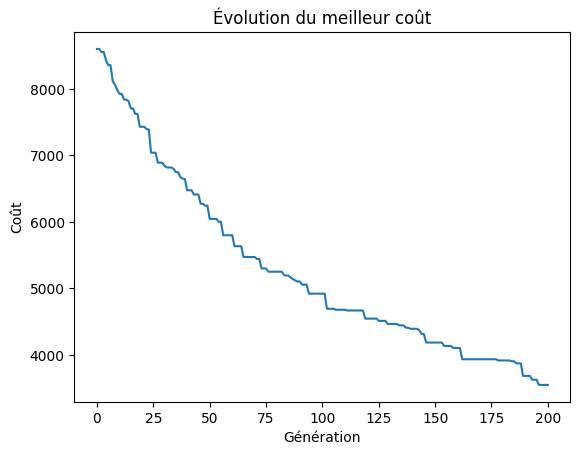


Meilleur chemin trouvé (extrait):
Départ: [1, 96, 56]...[95, 36, 1]
Longueur: 101 villes
Coût total: 3549


In [5]:
if __name__ == "__main__":
    try:
        liste = ["../data/matrice_routes_ordre_10.csv",
                 "../data/matrice_routes_ordre_20.csv",
                 "../data/matrice_routes_ordre_30.csv",
                 "../data/matrice_routes_ordre_40_Difficile.csv",
                 "../data/matrice_routes_ordre_50.csv",
                 "../data/matrice_routes_ordre_75.csv",
                 "../data/matrice_routes_ordre_100.csv",
                 "../data/matrice_routes_ordre_generation_aleatoire.csv"
                 ]
        for i in range(len(liste)):
            file_path = liste[i]  # Remplacez par votre chemin
            print(f"Chargement du fichier {file_path}...")
            matrix, collecte = load_adjacency_matrix_and_collecte(file_path)
            
            print("\nParamètres du problème:")
            print(f"- Nombre de villes: {len(matrix)}")
            print(f"- Points de collecte: {collecte}")
            print(f"- Taille de la matrice: {matrix.shape}")
            
            # Résolution
            solver = GeneticTSP(matrix, collecte)
            solution, cost = solver.solve(
                population_size=100,
                generations=200,
                mutation_rate=0.2,
                elite_size=10
            )
            
            print("\nMeilleur chemin trouvé (extrait):")
            print(f"Départ: {solution[:3]}...{solution[-3:]}")
            print(f"Longueur: {len(solution)} villes")
            print(f"Coût total: {cost}")
        
    except Exception as e:
        print(f"Erreur: {str(e)}")

Source :

https://github.com/gregory-chatelier/tsp
https://www.malaspinas.academy/prog_seq/exercices/09_voyageur_commerce/index.html
https://igm.univ-mlv.fr/~dr/XPOSE2013/tleroux_genetic_algorithm/fonctionnement.html